# Imports

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml
sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

# Some Initialization Parameters for AWS

In [2]:
# code to create a new bucket or use an existing bucket with allowed permissions
useExistingBucket = True
#if true , use exiting models else create a new model, make sure name is unique and add it to our 
#existing bucket only create a new folder
FreireBucket = "freirebros-deepracer" #bucketname , this is global bucket (S3 Bucket)

#the pretrained folder is incase yo have an old model already trained
#if you have non then just call it ""
#DO NOT PUT A  SLASH AT THE END IT MESSES EVERYTHING UP
pretrainedModelPrefix = "AndreiModels/Model-Andrei-Trial-4-usingT3-SM" #this is the prefix name (a folder within sagemaker S3)
#new model directory
NewModelPrefix = "AndreiModels/Model-Andrei-Trial-5-usingT4-SM"

# Select the instance type
instance_type = "ml.c4.2xlarge"
#instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"


if not FreireBucket: 
    raise SystemExit("Please Enter a Bucket Name")

# Starting SageMaker session
sage_session = sagemaker.session.Session(default_bucket = FreireBucket)

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

# AWS Resources setup 
## taken from AWS examples - DO NOT CHANGE

In [3]:
#Fetch S3 Bucket Resource
if not NewModelPrefix:
    raise systemExit("pleaser Enter a Prefix Name (Folder where the model is stored)")
# S3 bucket
if not useExistingBucket:
    s3_bucket = sage_session.default_bucket()
else:
    s3_bucket = FreireBucket
# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = NewModelPrefix

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))

#set permisions Resource
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

#In case reader want to implement themselves
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

#build AWS Docker Resource

%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)
    
    

#configure VPC Resource
ec2 = boto3.client('ec2')

#
# Check if the user has Deepracer-VPC and use that if its present. This will have all permission.
# This VPC will be created when you have used the Deepracer console and created one model atleast
# If this is not present. Use the default VPC connnection
#
deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups']\
                             if group['GroupName'].startswith("aws-deepracer-")]

# deepracer_security_groups = False
if(deepracer_security_groups):
    print("Using the DeepRacer VPC stacks. This will be created if you run one training job from console.")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] \
                     if "Tags" in vpc for val in vpc['Tags'] \
                     if val['Value'] == 'deepracer-vpc'][0]
    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc]
else:
    print("Using the default VPC stacks")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

    deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                                 if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

#create Route Table resourses
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()
    



Using s3 bucket freirebros-deepracer
Model checkpoints and other metadata will be stored at: 
s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-5-usingT4-SM
Using Sagemaker IAM role arn: 
arn:aws:iam::204747776045:role/service-role/AmazonSageMaker-ExecutionRole-20210210T204480


1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Creating sagemaker container
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image sagemaker-docker-cpu from Dockerfile
$ docker build -t sagemaker-docker-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-east-1
Sending build context to Docker daemon  44.73MB
Step 1/22 : ARG CPU_OR_GPU
Step 2/22 : ARG AWS_REGION
Step 3/22 : FROM 520713654638.dkr.ecr.$AWS_REGION.amazonaws.com/sagemaker-tensorflow-scriptmode:1.12.0-$CPU_OR_GPU-py3
1.12.0-cpu-py3: Pulling from sagemaker-tensorflow-scriptmode
9ff7e2

7 upgraded, 145 newly installed, 0 to remove and 102 not upgraded.
Need to get 77.0 MB of archives.
After this operation, 355 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu xenial/main amd64 python3.6-dev amd64 3.6.13-1+xenial2 [501 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxau6 amd64 1:1.0.8-1 [8376 B]
Get:3 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxdmcp6 amd64 1:1.1.2-1.1 [11.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxcb1 amd64 1.11.1-1ubuntu1 [40.0 kB]
Get:5 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libx11-data all 2:1.6.3-1ubuntu2.2 [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libx11-6 amd64 2:1.6.3-1ubuntu2.2 [572 kB]
Get:7 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxext6 amd64 2:1.3.3-1 [29.4 kB]
Get:8 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libdrm-common all 2.4.91-2~16.04.1 [4764 B]
Get:9 http://ar

Get:79 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libvpx3 amd64 1.5.0-2ubuntu1.1 [732 kB]
Get:80 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libwavpack1 amd64 4.75.2-2ubuntu0.2 [74.8 kB]
Get:81 http://archive.ubuntu.com/ubuntu xenial/main amd64 libwebp5 amd64 0.4.4-1 [165 kB]
Get:82 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libx264-148 amd64 2:0.148.2643+git5c65704-1 [606 kB]
Get:83 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libx265-79 amd64 1.9-3 [965 kB]
Get:84 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libxvidcore4 amd64 2:1.3.4-1 [206 kB]
Get:85 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libzvbi-common all 0.2.35-10 [32.5 kB]
Get:86 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libzvbi0 amd64 0.2.35-10 [235 kB]
Get:87 http://archive.ubuntu.com/ubuntu xenial-updates/universe amd64 libavcodec-ffmpeg56 amd64 7:2.8.17-0ubuntu0.1 [4097 kB]
Get:88 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu xenial

(Reading database ... 12981 files and directories currently installed.)
Preparing to unpack .../libxau6_1%3a1.0.8-1_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.8-1) ...
Selecting previously unselected package libxdmcp6:amd64.
Preparing to unpack .../libxdmcp6_1%3a1.1.2-1.1_amd64.deb ...
Unpacking libxdmcp6:amd64 (1:1.1.2-1.1) ...
Selecting previously unselected package libxcb1:amd64.
Preparing to unpack .../libxcb1_1.11.1-1ubuntu1_amd64.deb ...
Unpacking libxcb1:amd64 (1.11.1-1ubuntu1) ...
Selecting previously unselected package libx11-data.
Preparing to unpack .../libx11-data_2%3a1.6.3-1ubuntu2.2_all.deb ...
Unpacking libx11-data (2:1.6.3-1ubuntu2.2) ...
Selecting previously unselected package libx11-6:amd64.
Preparing to unpack .../libx11-6_2%3a1.6.3-1ubuntu2.2_amd64.deb ...
Unpacking libx11-6:amd64 (2:1.6.3-1ubuntu2.2) ...
Selecting previously unselected package libxext6:amd64.
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selec

Preparing to unpack .../python3.6_3.6.13-1+xenial2_amd64.deb ...
Unpacking python3.6 (3.6.13-1+xenial2) over (3.6.8-1+xenial1) ...
Preparing to unpack .../libpython3.6-stdlib_3.6.13-1+xenial2_amd64.deb ...
Unpacking libpython3.6-stdlib:amd64 (3.6.13-1+xenial2) over (3.6.8-1+xenial1) ...
Preparing to unpack .../python3.6-minimal_3.6.13-1+xenial2_amd64.deb ...
Unpacking python3.6-minimal (3.6.13-1+xenial2) over (3.6.8-1+xenial1) ...
Preparing to unpack .../libpython3.6-minimal_3.6.13-1+xenial2_amd64.deb ...
Unpacking libpython3.6-minimal:amd64 (3.6.13-1+xenial2) over (3.6.8-1+xenial1) ...
Selecting previously unselected package libopenal-data.
Preparing to unpack .../libopenal-data_1%3a1.16.0-3_all.deb ...
Unpacking libopenal-data (1:1.16.0-3) ...
Selecting previously unselected package libopenal1:amd64.
Preparing to unpack .../libopenal1_1%3a1.16.0-3_amd64.deb ...
Unpacking libopenal1:amd64 (1:1.16.0-3) ...
Selecting previously unselected package libfribidi0:amd64.
Preparing to unpack .

Selecting previously unselected package libass5:amd64.
Preparing to unpack .../libass5_0.13.1-1_amd64.deb ...
Unpacking libass5:amd64 (0.13.1-1) ...
Selecting previously unselected package libbluray1:amd64.
Preparing to unpack .../libbluray1_1%3a0.9.2-2_amd64.deb ...
Unpacking libbluray1:amd64 (1:0.9.2-2) ...
Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../libgme0_0.6.0-3ubuntu0.16.04.1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.0-3ubuntu0.16.04.1) ...
Selecting previously unselected package libmodplug1:amd64.
Preparing to unpack .../libmodplug1_1%3a0.8.8.5-2_amd64.deb ...
Unpacking libmodplug1:amd64 (1:0.8.8.5-2) ...
Selecting previously unselected package libssh-gcrypt-4:amd64.
Preparing to unpack .../libssh-gcrypt-4_0.6.3-4.3ubuntu0.6_amd64.deb ...
Unpacking libssh-gcrypt-4:amd64 (0.6.3-4.3ubuntu0.6) ...
Selecting previously unselected package libavformat-ffmpeg56:amd64.
Preparing to unpack .../libavformat-ffmpeg56_7%3a2.8.17-0ubuntu0.1_amd64.deb ...
U

Selecting previously unselected package python3-opengl.
Preparing to unpack .../python3-opengl_3.0.2-1_all.deb ...
Unpacking python3-opengl (3.0.2-1) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../x11-xkb-utils_7.7+2_amd64.deb ...
Unpacking x11-xkb-utils (7.7+2) ...
Selecting previously unselected package xserver-common.
Preparing to unpack .../xserver-common_2%3a1.18.4-0ubuntu0.11_all.deb ...
Unpacking xserver-common (2:1.18.4-0ubuntu0.11) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.18.4-0ubuntu0.11_amd64.deb ...
Unpacking xvfb (2:1.18.4-0ubuntu0.11) ...
Selecting previously unselected package libav-tools.
Preparing to unpack .../libav-tools_7%3a2.8.17-0ubuntu0.1_all.deb ...
Unpacking libav-tools (7:2.8.17-0ubuntu0.1) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
Processing triggers for systemd (229-4ubuntu21.21) ...
Processing triggers for mime-support (3.59ubuntu1) ...
Setting up libxau6:amd64 (

Setting up libpixman-1-0:amd64 (0.33.6-1) ...
Setting up libxt6:amd64 (1:1.1.5-0ubuntu1) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libxpm4:amd64 (1:3.5.11-1ubuntu0.16.04.1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libxfont1:amd64 (1:1.5.1-1ubuntu0.16.04.4) ...
Setting up libxkbfile1:amd64 (1:1.0.9-0ubuntu1) ...
Setting up libxrender1:amd64 (1:0.9.9-0ubuntu1) ...
Setting up libglu1-mesa:amd64 (9.0.0-2.1) ...
Setting up python3-opengl (3.0.2-1) ...
Setting up x11-xkb-utils (7.7+2) ...
Setting up xserver-common (2:1.18.4-0ubuntu0.11) ...
Setting up xvfb (2:1.18.4-0ubuntu0.11) ...
Setting up libav-tools (7:2.8.17-0ubuntu0.1) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
Processing triggers for systemd (229-4ubuntu21.21) ...
Removing intermediate container 9c4fbf43a923
 ---> 40b970725691
Step 6/22 : RUN     cd /tmp &&     wget http://download.redis.io/redis-stable.tar.gz &&     tar xvzf redis-stable.tar.gz &&     cd redis-stable &&     make &&     m

redis-stable/deps/jemalloc/test/integration/aligned_alloc.c
redis-stable/deps/jemalloc/test/integration/mallocx.c
redis-stable/deps/jemalloc/test/integration/extent.sh
redis-stable/deps/jemalloc/test/integration/overflow.c
redis-stable/deps/jemalloc/test/integration/allocated.c
redis-stable/deps/jemalloc/test/integration/thread_tcache_enabled.c
redis-stable/deps/jemalloc/test/integration/extent.c
redis-stable/deps/jemalloc/test/integration/rallocx.c
redis-stable/deps/jemalloc/test/integration/posix_memalign.c
redis-stable/deps/jemalloc/test/integration/xallocx.sh
redis-stable/deps/jemalloc/test/integration/xallocx.c
redis-stable/deps/jemalloc/test/integration/thread_arena.c
redis-stable/deps/jemalloc/test/include/
redis-stable/deps/jemalloc/test/include/test/
redis-stable/deps/jemalloc/test/include/test/SFMT-params132049.h
redis-stable/deps/jemalloc/test/include/test/jemalloc_test_defs.h.in
redis-stable/deps/jemalloc/test/include/test/SFMT-params86243.h
redis-stable/deps/jemalloc/test/

/bin/sh: 1: pkg-config: not found
    CC Makefile.dep
/bin/sh: 1: pkg-config: not found
rm -rf redis-server redis-sentinel redis-cli redis-benchmark redis-check-rdb redis-check-aof *.o *.gcda *.gcno *.gcov redis.info lcov-html Makefile.dep dict-benchmark
rm -f adlist.d quicklist.d ae.d anet.d dict.d server.d sds.d zmalloc.d lzf_c.d lzf_d.d pqsort.d zipmap.d sha1.d ziplist.d release.d networking.d util.d object.d db.d replication.d rdb.d t_string.d t_list.d t_set.d t_zset.d t_hash.d config.d aof.d pubsub.d multi.d debug.d sort.d intset.d syncio.d cluster.d crc16.d endianconv.d slowlog.d scripting.d bio.d rio.d rand.d memtest.d crcspeed.d crc64.d bitops.d sentinel.d notify.d setproctitle.d blocked.d hyperloglog.d latency.d sparkline.d redis-check-rdb.d redis-check-aof.d geo.d lazyfree.d module.d evict.d expire.d geohash.d geohash_helper.d childinfo.d defrag.d siphash.d rax.d t_stream.d listpack.d localtime.d lolwut.d lolwut5.d lolwut6.d acl.d gopher.d tracking.d connection.d tls.d sha256

cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_bit.o lua_bit.c
ar rc liblua.a lapi.o lcode.o ldebug.o ldo.o ldump.o lfunc.o lgc.o llex.o lmem.o lobject.o lopcodes.o lparser.o lstate.o lstring.o ltable.o ltm.o lundump.o lvm.o lzio.o strbuf.o fpconv.o lauxlib.o lbaselib.o ldblib.o liolib.o lmathlib.o loslib.o ltablib.o lstrlib.o loadlib.o linit.o lua_cjson.o lua_struct.o lua_cmsgpack.o lua_bit.o	# DLL needs all object files
ranlib liblua.a
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua.o lua.c
cc -o lua  lua.o liblua.a -lm 
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o luac.o luac.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o print.o print.c
cc -o luac  luac.o print.o liblua.a -lm 
make[3]: Leaving directory '/tmp/redis-stable/deps/lua/src'
MAKE hdr_histogram
cd hdr_histogram && make
make[3]: Entering d

config.status: executing include/jemalloc/internal/private_symbols_jet.awk commands
config.status: executing include/jemalloc/internal/public_namespace.h commands
config.status: executing include/jemalloc/internal/public_unnamespace.h commands
config.status: executing include/jemalloc/internal/size_classes.h commands
config.status: executing include/jemalloc/jemalloc_protos_jet.h commands
config.status: executing include/jemalloc/jemalloc_rename.h commands
config.status: executing include/jemalloc/jemalloc_mangle.h commands
config.status: executing include/jemalloc/jemalloc_mangle_jet.h commands
config.status: executing include/jemalloc/jemalloc.h commands
jemalloc version   : 5.1.0-0-g0
library revision   : 2

CONFIG             : --with-version=5.1.0-0-g0 --with-lg-quantum=3 --with-jemalloc-prefix=je_ 'CFLAGS=-std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops ' LDFLAGS=
CC                 : gcc
CONFIGURE_CFLAGS   : -std=gnu11 -Wall -Wsign-compare -Wundef -Wno-format-zero-length -pipe -g3 

nm -a src/prof.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/prof.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/rtree.sym.o src/rtree.c
nm -a src/rtree.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/rtree.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/stats.sym.o src/stats.c
nm -a src/stats.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/stats.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/sz.sym.o src/sz.c
nm -a src/sz.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/sz.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/tcache

    CC t_zset.o
    CC t_hash.o
    CC config.o
    CC aof.o
    CC pubsub.o
    CC multi.o
    CC debug.o
    CC sort.o
    CC intset.o
    CC syncio.o
    CC cluster.o
    CC crc16.o
    CC endianconv.o
    CC slowlog.o
    CC scripting.o
    CC bio.o
    CC rio.o
    CC rand.o
    CC memtest.o
    CC crcspeed.o
    CC crc64.o
    CC bitops.o
    CC sentinel.o
    CC notify.o
    CC setproctitle.o
    CC blocked.o
    CC hyperloglog.o
    CC latency.o
    CC sparkline.o
    CC redis-check-rdb.o
    CC redis-check-aof.o
    CC geo.o
    CC lazyfree.o
    CC module.o
    CC evict.o
    CC expire.o
    CC geohash.o
    CC geohash_helper.o
    CC childinfo.o
    CC defrag.o
    CC siphash.o
    CC rax.o
    CC t_stream.o
    CC listpack.o
    CC localtime.o
    CC lolwut.o
    CC lolwut5.o
    CC lolwut6.o
    CC acl.o
    CC gopher.o
    CC tracking.o
    CC connection.o
    CC tls.o
    CC sha256.o
    CC timeout.o
    CC setcpuaffinity.o
    CC monotonic.o
    CC mt19937-64.o
    LINK

  Running setup.py bdist_wheel for annoy: started
  Running setup.py bdist_wheel for annoy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/b5/58/70/727ae337cd1e7013d8d25dba8e590b4a1d2541e528e941736f
  Running setup.py bdist_wheel for PyOpenGL: started
  Running setup.py bdist_wheel for PyOpenGL: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
  Running setup.py bdist_wheel for bokeh: started
  Running setup.py bdist_wheel for bokeh: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/fb/f8/47/09700d9a19cbcbf0b7a3130690b75c0d6ff80fbda0b1774c7c
  Running setup.py bdist_wheel for rl-coach-slim: started
  Running setup.py bdist_wheel for rl-coach-slim: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e3/d9/c3/9f57386e242e40632f29b8377a39e1dc78a9be5525882509c7
  Running setup.py bdist_wheel for retrying: started
  Running setup.p

  Found existing installation: Werkzeug 0.15.4
    Uninstalling Werkzeug-0.15.4:
      Successfully uninstalled Werkzeug-0.15.4
  Found existing installation: Flask 1.0.3
    Uninstalling Flask-1.0.3:
      Successfully uninstalled Flask-1.0.3
  Found existing installation: inotify-simple 1.1.8
    Uninstalling inotify-simple-1.1.8:
      Successfully uninstalled inotify-simple-1.1.8
  Running setup.py install for inotify-simple: started
    Running setup.py install for inotify-simple: finished with status 'done'
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1
  Found existing installation: sagemaker-containers 2.4.9
    Uninstalling sagemaker-containers-2.4.9:
      Successfully uninstalled sagemaker-containers-2.4.9
  Running setup.py install for sagemaker-containers: started
    Running setup.py install for sagemaker-containers: finished with status 'done'
You are using pip version 18.1, however version 21.0.1 is av

Pushing docker image to ECR repository 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu

$ docker push 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu
The push refers to repository [204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu]
4616499bc118: Preparing
a898c3d3bc50: Preparing
607e290f612f: Preparing
c698ffe75a2e: Preparing
7f4dc825d975: Preparing
b00007224ae2: Preparing
828a4454b850: Preparing
07b5f8167057: Preparing
264028e34d3e: Preparing
8b5ac3343549: Preparing
dda680c8abf1: Preparing
db9924d7b937: Preparing
d657216bf051: Preparing
8f12c2c67bff: Preparing
eeeaa8644512: Preparing
9566fd64cedb: Preparing
3f6827ca25ec: Preparing
955b7b824a1e: Preparing
86bd6a7e10d7: Preparing
06cc13f4dd23: Preparing
8667e75ed9a8: Preparing
bfe2333d29b9: Preparing
04fde66ee1d6: Preparing
96fa5a6e9cc3: Preparing
a02c14edf37f: Preparing
4c54072a5034: Preparing
49652298c779: Preparing
e15278fcccca: Preparing
739482a9723d: Preparing
b00007224ae2: Waitin

# Set Up Training Environment


In [4]:
#copy any custom files such as 
#custom reward function
#meta_data
#presets -> action space
#attention layer

s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/andrei_reward_optimized_turns.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/front_continuous_action_DR.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py



s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-5-usingT4-SM
upload: src/artifacts/rewards/andrei_reward_optimized_turns.py to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-5-usingT4-SM/customer_reward_function.py
upload: src/artifacts/actions/front_continuous_action_DR.json to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-5-usingT4-SM/model/model_metadata.json


In [5]:
#set Metric we want to collect
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

# TRAIN
Configure hyper parameters
exploration type che k : https://intellabs.github.io/coach/components/exploration_policies/index.html
Categorical
i will choose EGreedy

In [6]:
estimator = RLEstimator(entry_point="training_worker.py",
                        source_dir='src',
                        image_uri=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Continuous",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.95",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
                            ,"pretrained_s3_bucket": FreireBucket
                            ,"pretrained_s3_prefix": pretrainedModelPrefix
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: deepracer-notebook-2021-03-28-18-55-07-532


In [7]:
#Get Info
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

# AWS Simulation and Robot Resources 
##  taken from AWS examples - DO NOT CHANGE

In [9]:
#kinesis video stream
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

# robomaker
robomaker = boto3.client("robomaker")

#simulation
#we shoould consider usin gazebo version 9
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}
        
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

        

vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    envriron_vars = {
        "S3_YAML_NAME": s3_yaml_name,
        "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
        "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
        "WORLD_NAME": world_name,
        "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
        "APP_REGION": aws_region,
        "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
        "ROLLOUT_IDX": str(job_no)
    }

    simulation_application = {"application":simulation_app_arn,
                              "launchConfig": {"packageName": "deepracer_simulation_environment",
                                               "launchFile": "distributed_training.launch",
                                               "environmentVariables": envriron_vars}
                             }
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Fail",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)
    time.sleep(5)
    

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:204747776045:stream/dr-kvs-deepracer-notebook-2021-03-28-18-55-07-532/1616957838673"
}
Created kinesis video stream dr-kvs-deepracer-notebook-2021-03-28-18-55-07-532
Using the latest simapp from public s3 bucket
download: s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz to ./deepracer-simapp.tar.gz
delete: s3://freirebros-deepracer/robomaker/simulation_ws.tar.gz
upload: ./deepracer-simapp.tar.gz to s3://freirebros-deepracer/robomaker/simulation_ws.tar.gz
deepracer-notebook-application210328-185753
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:204747776045:simulation-application/deepracer-notebook-application210328-185753/1616957873426
Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-7q6vc4fsl9c7


In [10]:
    
s3_yaml_name="training_params.yaml"
world_name = "Monaco_building"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['SAGEMAKER_SHARED_S3_BUCKET']  = s3_bucket
yaml_config['SAGEMAKER_SHARED_S3_PREFIX']  = s3_prefix
yaml_config['TRAINING_JOB_ARN']            = training_job_arn
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/training_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/training".format(s3_prefix)
yaml_config['AWS_REGION']                  = aws_region
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['KINESIS_VIDEO_STREAM_NAME']   = kvs_stream_name
yaml_config['REWARD_FILE_S3_KEY']          = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config['MODEL_METADATA_FILE_S3_KEY']  = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config['NUM_WORKERS']                 = num_simulation_workers
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml


JOB_TYPE                                : TRAINING
WORLD_NAME                              : Monaco_building
SAGEMAKER_SHARED_S3_BUCKET              : freirebros-deepracer
SAGEMAKER_SHARED_S3_PREFIX              : AndreiModels/Model-Andrei-Trial-5-usingT4-SM
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:204747776045:training-job/deepracer-notebook-2021-03-28-18-55-07-532
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Trial-5-usingT4-SM/training_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Trial-5-usingT4-SM/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CHANGE_START_POSITION                   : true
ALTERNATE_D

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./training_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-5-usingT4-SM/training_params.yaml


In [11]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-7q6vc4fsl9c7)  

You can click on Gazebo after you open the above link to start the simulator.

# Lauch Simulation with parameters

In [12]:
#tracks you can use, there may be more now need to recheck....
# Albert.world                      Mexico_track.world                reinvent_wood.world
# AmericasGeneratedInclStart.world  Monaco_building.world             Singapore_building.world
# Aragon.world                      Monaco.world                      Singapore_f1.world
# Austin.world                      New_York_Track.world              Singapore.world
# AWS_track.world                   Oval_track.world                  Spain_track_f1.world
# Belille.world                     reInvent2019_track.world          Spain_track.world
# Bowtie_track.world                reInvent2019_wide_mirrored.world  Straight_track.world
# Canada_Training.world             reInvent2019_wide.world           Tokyo_Training_track.world
# China_track.world                 reinvent_base_jeremiah.world      Vegas_track.world
# FS_June2020.world                 reinvent_base.world               Virtual_May19_Train_track.world
# July_2020.world                   reinvent_carpet.world
# LGSWide.world                     reinvent_concrete.world

# PLOT RESULTS

In [13]:
#create ploting temp directories
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-03-28-18-55-07-532


Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/training_metrics.json...


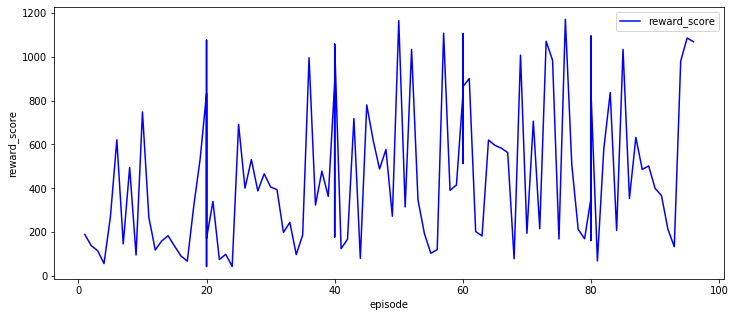

In [52]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
viewModelMetrics = NewModelPrefix
training_metrics_path = "{}/{}".format(viewModelMetrics, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

# Evaluation

In [53]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = s3_bucket
yaml_config['MODEL_S3_PREFIX']             = s3_prefix
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

display(Markdown(generate_robomaker_links(job_arns, aws_region)))

JOB_TYPE                                : EVALUATION
WORLD_NAME                              : reInvent2019_track
MODEL_S3_BUCKET                         : freirebros-deepracer
MODEL_S3_PREFIX                         : AndreiModels/Model-Andrei-Trial-4-usingT3-SM
AWS_REGION                              : us-east-1
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/iteration-data/evaluation
NUMBER_OF_TRIALS                        : 5
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CAR_COLOR                               : Grey
NUMBER_OF_RESETS                        : 10000
PENALTY_SECONDS                         : 2.0
IS_CONTINUOUS                           : false
OFF_TRACK_PENALTY                       : 0.0


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./evaluation_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_params.yaml
Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-ygctvwty6wrx


> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-ygctvwty6wrx)  

You can click on Gazebo after you open the above link to start the simulator.

## Plot Evaluation

In [54]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_metrics.json.....................................


,trial,completion_percentage,elapsed_time
0,1,100,25.42


# Head To Head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"
if not s3_prefix_2:
    raise Exception("Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between")

print("Using s3 bucket {}".format(s3_bucket_2))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket_2, s3_prefix_2))


s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MODEL_S3_PREFIX']             = [s3_prefix,
                                              s3_prefix_2]
yaml_config['MODEL_METADATA_FILE_S3_KEY']  =["{}/model/model_metadata.json".format(s3_prefix),
                                             "{}/model/model_metadata.json".format(s3_prefix_2)]
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = [s3_bucket,
                                              s3_bucket_2]
yaml_config['METRICS_S3_OBJECT_KEY']       = ["{}/evaluation_metrics.json".format(s3_prefix),
                                              "{}/evaluation_metrics.json".format(s3_prefix_2)]
yaml_config['SIMTRACE_S3_BUCKET']          = [s3_bucket,
                                              s3_bucket_2]
yaml_config['SIMTRACE_S3_PREFIX']          = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MP4_S3_OBJECT_PREFIX']        = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)
    
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

## Plot H2H Evaluation

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_1 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_1['elapsed_time'] = df_1['elapsed_time_in_milliseconds']/1000
df_1 = df_1[['trial', 'completion_percentage', 'elapsed_time']]

display(df_1)

evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_2 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_2['elapsed_time'] = df_2['elapsed_time_in_milliseconds']/1000
df_2 = df_2[['trial', 'completion_percentage', 'elapsed_time']]

display(df_2)

# CLEAN UP TRAININING

In [16]:
# Cancelling robomaker job
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

# Stopping sagemaker training job
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

ClientError: An error occurred (ValidationException) when calling the StopTrainingJob operation: The request was rejected because the training job is in status Failed.

# Remove Docker

In [17]:
#if you ever run this Docker/Cell please do not forget to clean and remove docker
!docker rm -f $(docker ps -a -q);
!docker rmi -f $(docker images -q);

"docker rm" requires at least 1 argument.
See 'docker rm --help'.

Usage:  docker rm [OPTIONS] CONTAINER [CONTAINER...]

Remove one or more containers
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu:latest
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu@sha256:311e33cc5597dec45898b8425ceaa7a4bfea37ee14d1e5ddf13a3177f3f822d4
Untagged: sagemaker-docker-cpu:latest
Deleted: sha256:a904ab95c7a35b830a5267f566bd28bede8d307a7a27f60c24e40cbddfb0bc17
Deleted: sha256:b4b253ed4565b8d70247ccde7115cf6e300111b22c2b62fa2ad3af3261a245a5
Deleted: sha256:1d004049bb6046439ca5d661098fee69f921ddc0dc7c57b2eddd793b4b248757
Deleted: sha256:d39a8e35ba8a9fb716015c5299080cd237f4674d28b9854accbf1336270c8779
Deleted: sha256:77464388d93440bdf5d1443c6847c8cc6b3020840fc5716ac7db67a1189eb27a
Deleted: sha256:3d283a45ac5bb1a882adb2285b810db1a7b94fc567cc53ee511e796bf45dbcc3
Deleted: sha256:ac9d0431976b42bf64834b2f491e4c059471a928b24cd47e79c73d48a88a0b08
Deleted: sha2

# Clean Up simulation 

In [18]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '16ff5a40-f9b5-4f98-a30f-07732d059d02',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 27 Mar 2021 23:27:40 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '16ff5a40-f9b5-4f98-a30f-07732d059d02',
   'x-amz-apigw-id': 'c3rY-HVtIAMFgiw=',
   'x-amzn-trace-id': 'Root=1-605fbf6c-73e272b45b77ca7d225dcc3b'},
  'RetryAttempts': 0}}

# Clean S3 Buckets

In [19]:
# Uncomment if you only want to clean the s3 bucket
sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
!aws s3 rm --recursive {sagemaker_s3_folder}

robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
!aws s3 rm --recursive {robomaker_s3_folder}

robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
!aws s3 rm --recursive {robomaker_sim_app}

model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
!aws s3 rm --recursive {model_output}

delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/customer_reward_function.py
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/hyperparameters.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/model/model_metadata.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/ip.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/training_params.yaml
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/done
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/output/model.tar.gz
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/profiler-output/system/incremental/2021032722/1616884800.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/profiler-output/system/incremental/2021032722/1616884740.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-